In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import xgboost as xgb
from pathlib import Path

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
import importlib
import utils.data_processing_snapshot_feature_label as snapshot_module
import src.models.xgb as models
importlib.reload(snapshot_module)
importlib.reload(models)

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table
from utils.data_processing_snapshot_feature_label import gold_features_labels_snapshot_creation, train_test_OOT_simulation_months
from src.models.xgb import feature_label_XGB_training, feature_label_XGB_get_X_y, optuna_mlflow_hyperparamter_tuning_xgb, shap_explainer_feature_set_generator




/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datetime import datetime
datetime.now().strftime("%Y%m%d_%H%M")
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/08 15:09:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:

print('Splitting dataset into train, test, OOT')
train, test, oot, sim = train_test_OOT_simulation_months()
gdf = gold_features_labels_snapshot_creation(spark=spark,
                                        gold_features_dir=Path('datamart/gold/feature_store__XGB_v1'),
                                        gold_labels_dir=Path('datamart/gold/label_store'),
                                        snapshots=train)
print('Running first stage of hyperparameter tuning')
X,y = feature_label_XGB_get_X_y(gdf)
study, best_model, model_path, best_model_artifact_uri = optuna_mlflow_hyperparamter_tuning_xgb(X,y,
                                       searchspace_dict={'n_trials':50},
                                       k_folds=5,
                                       save_model_dir='models/testing',
                                       expt_name='5_fold')

print('Running SHAP feature splitting')
feature_set = shap_explainer_feature_set_generator(artifact_uri=best_model_artifact_uri, X=X, y=y)
print('Running second stage hyperparameter tuning')
study, best_model, model_path, best_model_artifact_uri1 = optuna_mlflow_hyperparamter_tuning_xgb(X,y,
                                       searchspace_dict={'n_trials':50},
                                       k_folds=5,
                                       save_model_dir='models/testing',
                                       expt_name='5_fold_feature_select',
                                       feature_set=feature_set)
print('Evaluating on test set')
gdf = gold_features_labels_snapshot_creation(spark=spark,
                                        gold_features_dir=Path('datamart/gold/feature_store__XGB_v1'),
                                        gold_labels_dir=Path('datamart/gold/label_store'),
                                        snapshots=test)
X,y = feature_label_XGB_get_X_y(gdf)
proba = best_model.predict_proba(X)[:,1]
auc_test = roc_auc_score(y, proba)


print('Evaluating on oot set')
gdf = gold_features_labels_snapshot_creation(spark=spark,
                                        gold_features_dir=Path('datamart/gold/feature_store__XGB_v1'),
                                        gold_labels_dir=Path('datamart/gold/label_store'),
                                        snapshots=oot)
X,y = feature_label_XGB_get_X_y(gdf)
proba = best_model.predict_proba(X)[:,1]
auc_oot = roc_auc_score(y, proba)

print(f"cross_fold val AUC: {study.best_value}\n",
      f"test AUC: {auc_test}\n",
      f"OOT AUC: {auc_oot}\n")



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/08 09:25:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Splitting dataset into train, test, OOT


ValueError: not enough values to unpack (expected 4, got 3)

In [8]:
os.getcwd()

'/app/notebooks'

In [3]:
df = pd.read_parquet('outputs/model_tuning/20251108_132706/reference_data.parquet')

In [6]:
df

,Customer_ID,label,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Interest_Rate,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,...,High_Risk_Flag,High_Interest_Flag,Has_Multiple_Loans,Age_Bucket,Debt_to_Income_Bin,Min_Payment_Flag,PMET_Job_Indicator,Is_Year_End,feature_snapshot_date,default_probability
0,CUS_0x1037,0,5,4,4,2.0,0.500000,3,665.820007,40.697701,...,0,0,1,2,0,0,1,0,2023-01-01,0.238913
1,CUS_0x1069,0,4,6,9,10.0,12.560000,5,208.800003,25.233143,...,0,0,1,1,0,1,1,0,2023-01-01,0.051770
2,CUS_0x114a,0,0,7,2,2.0,15.950000,0,642.419983,27.525112,...,0,0,0,2,0,0,1,0,2023-01-01,0.179122
3,CUS_0x1184,0,3,5,3,11.0,6.740000,4,707.289978,26.689791,...,0,0,1,2,0,0,1,0,2023-01-01,0.220962
4,CUS_0x1297,1,9,8,9,30.0,14.270000,11,3916.469971,25.742142,...,0,1,1,2,0,1,1,0,2023-01-01,0.518807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4486,CUS_0xdf6,0,2,2,0,1.0,4.290000,2,454.359985,38.966488,...,0,0,0,3,0,0,0,0,2023-09-01,0.015382
4487,CUS_0xe23,0,8,6,1,18.0,14.180000,10,982.630005,33.897781,...,0,0,0,1,0,1,0,0,2023-09-01,0.092008
4488,CUS_0xe4e,0,3,3,0,9.0,16.160000,7,1323.250000,38.327251,...,0,0,0,0,0,1,1,0,2023-09-01,0.064620
4489,CUS_0xedd,0,4,4,4,10.0,0.000000,4,1136.849976,39.053761,...,0,0,1,1,0,1,1,0,2023-09-01,0.089399


In [101]:
print(best_model.get_booster().feature_names)

['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Interest_Rate', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Monthly_Inhand_Salary', 'Age', 'Credit_History_Months', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Spend_Level', 'Value_Level', 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Payday Loan', 'Personal Loan', 'Student Loan', 'unseen', 'fe_1', 'fe_2', 'fe_3', 'fe_4', 'fe_5', 'fe_6', 'fe_7', 'fe_8', 'fe_9', 'fe_10', 'fe_11', 'fe_12', 'fe_13', 'fe_14', 'fe_15', 'fe_16', 'fe_17', 'fe_18', 'fe_19', 'fe_20', 'Debt_to_Income_Ratio', 'Delayed_Payment_Rate', 'EMI_to_Income_Ratio', 'Investment_Rate', 'Loan_Diversity_Score', 'Click_Total', 'Click_Mean', 'Click_Variance', 'Debt_to_Click_Ratio', 'Income_to_Utilization', 'Investment_to_Clicks', 'Age_to_Credit_Age_Ratio', 'EMI_to_Debt_Ratio', 'Debt_to_Salary_Interaction', 'Debt_Interest_Product', 'Log_Debt'

In [1]:
study

NameError: name 'study' is not defined

/tmp/ipykernel_9/3715145721.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)


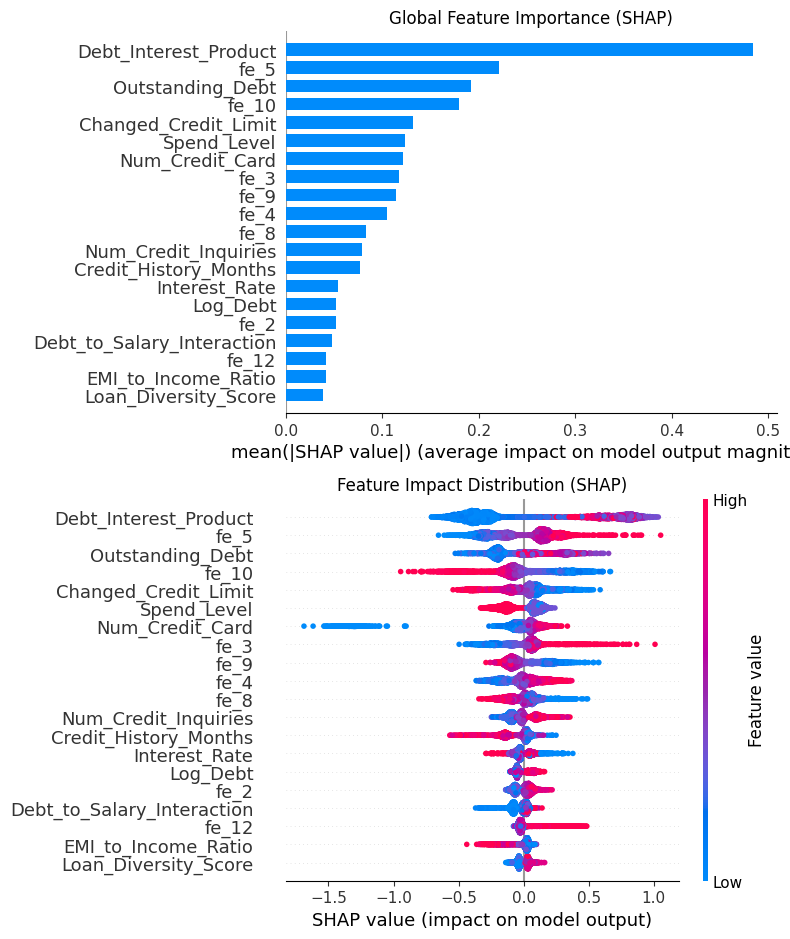

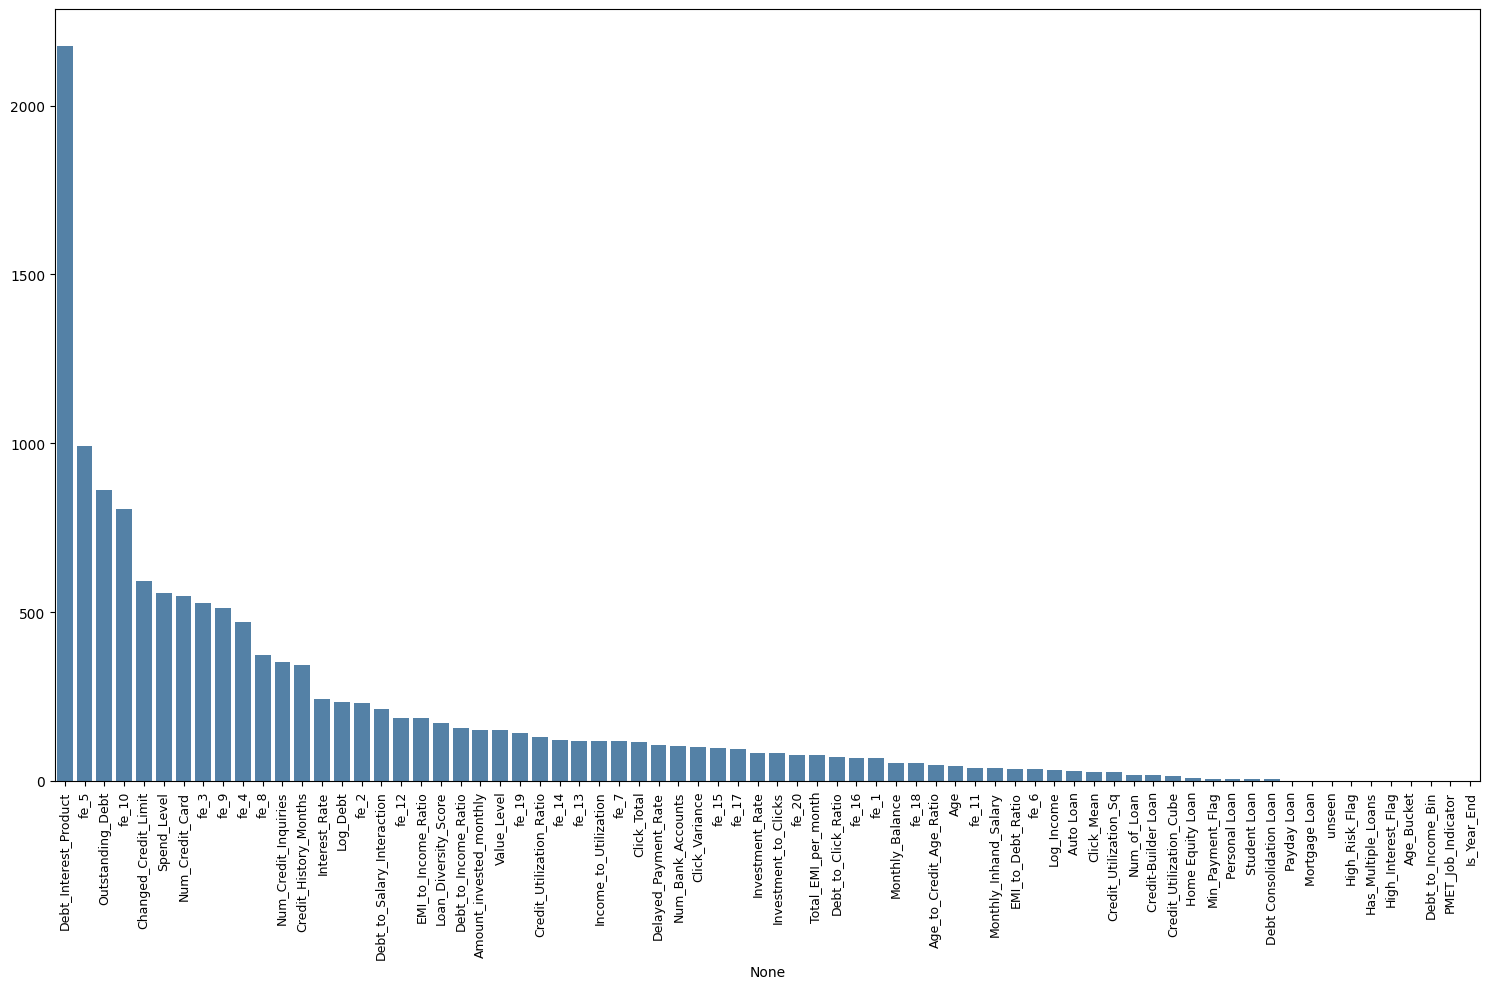

In [117]:
# load best xgb model then run shap feature importance
# plot the feature importance and dataframe for the shap values
import json
from pathlib import Path
import ast
import shap
import mlflow
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# --- configure paths and input data -------------------------------------------------
artifact_uri = (
    './mlruns/260016131701352376/models/m-965ac7cbc530491f98fa7cfa415fd7d5/artifacts'
)
loaded = mlflow.xgboost.load_model(artifact_uri)
booster = loaded if isinstance(loaded, xgb.Booster) else loaded.get_booster()



dmatrix = xgb.DMatrix(X, label=y, enable_categorical=True)

# --- compute SHAP values -----------------------------------------------------------
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(dmatrix)

# --- plot -------------------------------------------------------------------------
fig,axes = plt.subplots(nrows=2, ncols=1)
plt.sca(axes[0])
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
axes[0].set_title("Global Feature Importance (SHAP)")

plt.sca(axes[1])
shap.summary_plot(shap_values, X, show=False)
axes[1].set_title("Feature Impact Distribution (SHAP)")
fig.tight_layout()
fig.show()

shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_totals = shap_df.abs().sum(axis=0).sort_values(ascending=False)

fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(x=shap_totals.index, y=shap_totals.values, color="steelblue", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
fig.tight_layout()
fig.show()



DROPPING bin 1: 1 features with 0.1616 ---- due to <3 features in group
bin 2: 3 features with 0.2993
bin 3: 4 features with 0.3591
bin 4: 7 features with 0.4849
bin 5: 14 features with 0.6942
bin 6: 32 features with 0.8990
bin 7: 72 features with 1.0000


/tmp/ipykernel_9/1155476314.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)


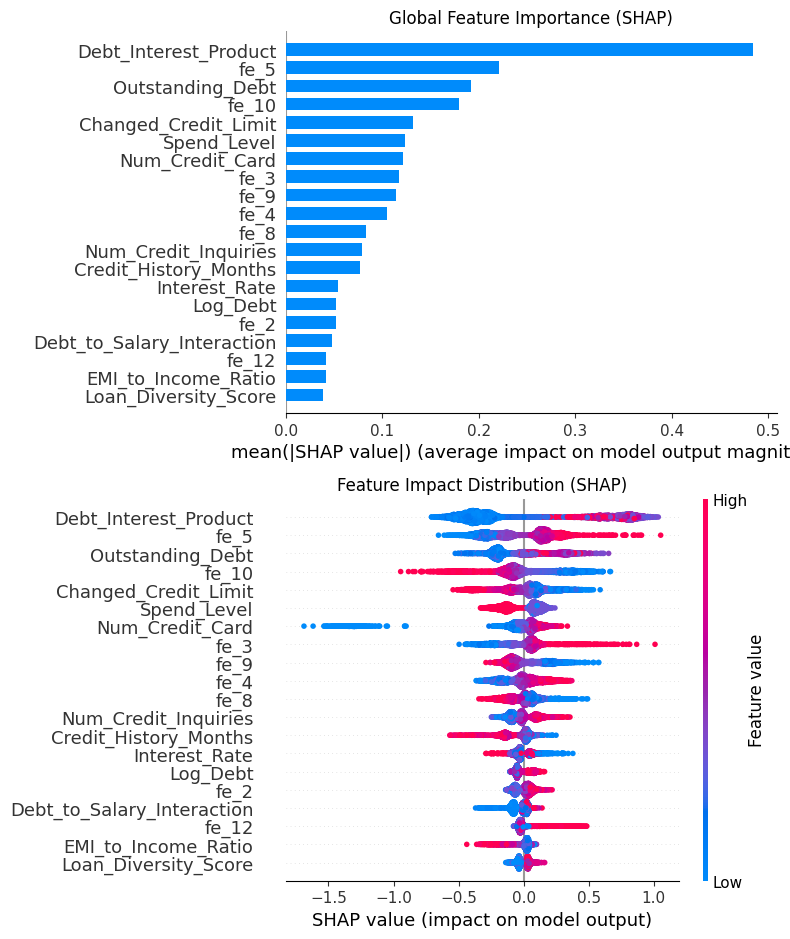

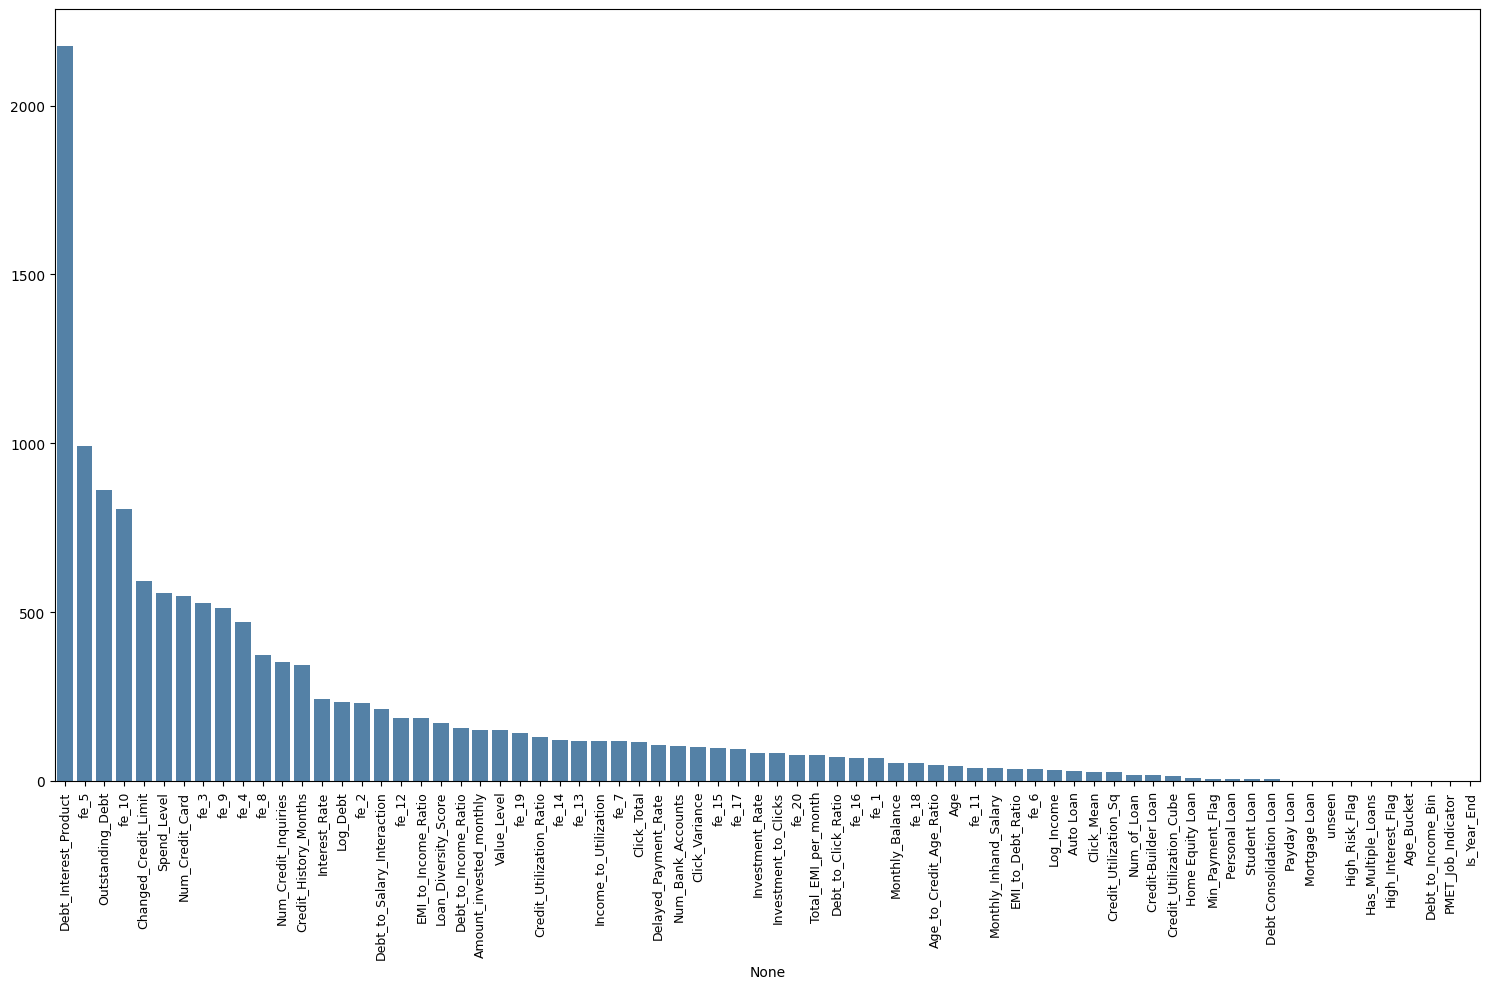

In [93]:
bin_cutting(shap_totals)

DROPPING bin 1: 1 features with 0.1616 ---- due to <3 features in group
bin 2: 3 features with 0.2993
bin 3: 4 features with 0.3591
bin 4: 7 features with 0.4849
bin 5: 14 features with 0.6942
bin 6: 32 features with 0.8990
bin 7: 72 features with 1.0000


{'20–30%': ['Debt_Interest_Product', 'fe_5', 'Outstanding_Debt'],
 '30–40%': ['Debt_Interest_Product', 'fe_5', 'Outstanding_Debt', 'fe_10'],
 '40–50%': ['Debt_Interest_Product',
  'fe_5',
  'Outstanding_Debt',
  'fe_10',
  'Changed_Credit_Limit',
  'Spend_Level',
  'Num_Credit_Card'],
 '50–70%': ['Debt_Interest_Product',
  'fe_5',
  'Outstanding_Debt',
  'fe_10',
  'Changed_Credit_Limit',
  'Spend_Level',
  'Num_Credit_Card',
  'fe_3',
  'fe_9',
  'fe_4',
  'fe_8',
  'Num_Credit_Inquiries',
  'Credit_History_Months',
  'Interest_Rate'],
 '70–90%': ['Debt_Interest_Product',
  'fe_5',
  'Outstanding_Debt',
  'fe_10',
  'Changed_Credit_Limit',
  'Spend_Level',
  'Num_Credit_Card',
  'fe_3',
  'fe_9',
  'fe_4',
  'fe_8',
  'Num_Credit_Inquiries',
  'Credit_History_Months',
  'Interest_Rate',
  'Log_Debt',
  'fe_2',
  'Debt_to_Salary_Interaction',
  'fe_12',
  'EMI_to_Income_Ratio',
  'Loan_Diversity_Score',
  'Debt_to_Income_Ratio',
  'Amount_invested_monthly',
  'Value_Level',
  'fe_19',


In [94]:

knee_from_shap(shap_totals)

(16,
 'Debt_to_Salary_Interaction',
 Index(['Debt_Interest_Product', 'fe_5', 'Outstanding_Debt', 'fe_10',
        'Changed_Credit_Limit', 'Spend_Level', 'Num_Credit_Card', 'fe_3',
        'fe_9', 'fe_4', 'fe_8', 'Num_Credit_Inquiries', 'Credit_History_Months',
        'Interest_Rate', 'Log_Debt', 'fe_2', 'Debt_to_Salary_Interaction'],
       dtype='object'),
 0.7446149587631226)

In [ ]:
import subprocess, sys

ui_proc = subprocess.Popen(
    [
        sys.executable,
        "-m",
        "mlflow",
        "ui",
        "--host", "0.0.0.0",
        "--port", "8888",
        # add these if you really need remote access:
        "--allowed-hosts", "*",
        "--cors-allowed-origins", "*",
    ],
    cwd="mlruns",
)


[MLflow] Security middleware enabled. Allowed hosts: *. CORS origins: *.
ERROR:    [Errno 98] Address already in use


In [ ]:
from pathlib import Path
import pandas as pd

label_store_dir = Path("datamart/gold/label_store")

# Dictionary keyed by file stem -> DataFrame
gold_label_store_frames = {
    file_path.stem: spark.read.parquet(str(file_path)).toPandas()
    for file_path in sorted(label_store_dir.glob("*.parquet"))
}




In [43]:
from pathlib import Path
import pandas as pd

label_store_dir = Path("datamart/silver/loan_daily")

# Dictionary keyed by file stem -> DataFrame
silver_label_store_frames = {
    file_path.stem: spark.read.parquet(str(file_path)).toPandas()
    for file_path in sorted(label_store_dir.glob("*.parquet"))
}




In [50]:
silver_label_store_frames['silver_loan_daily_2023_07_01'].to_csv('./silver_loan_daily_2023_07_01.csv')

In [48]:
gold_label_store_frames['gold_label_store_2023_07_01'].to_csv('./gold_label_store_2023_07_01.csv')

In [35]:
label_store_frames['gold_label_store_2023_07_01'].dtypes

loan_id          object
Customer_ID      object
label             int32
label_def        object
snapshot_date    object
dtype: object

In [41]:
set(label_store_frames['gold_label_store_2023_08_01']['Customer_ID']) & set(label_store_frames['gold_label_store_2023_07_01']['Customer_ID'])

set()